# Sprint13 TensorFlow

## コードリーディング

## 【問題1】スクラッチを振り返る
---
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。

（例）

-    重みを初期化する必要があった
-    エポックのループが必要だった


それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。

-   活性化関数が必要だった
-   損失関数の計算
-   フォワードとバックプロパゲーションの処理
-   各レイヤで重みとバイアスの値を更新
-   各レイヤで使用する最適化
-   バッチサイズ、学習率、各ノードにおける特徴量の数を定義
-   学習と予測を実施する
-   MSEなどの精度を計算し、表示する

## データセットの用意
---
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。

Iris Species

目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。

-  Iris-versicolor
-  Iris-virginica

In [91]:
import pandas as pd
iris = pd.read_csv("Iris.csv")

data = iris[iris['Species'] != 'Iris-setosa']
data = data.replace('Iris-versicolor', 0).replace('Iris-virginica', 1)

X = data.drop(columns=['Id','Species']).values
y = data['Species']

# print(X)
# print(y)


## 【問題2】スクラッチとTensorFlowの対応を考える
---
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

《サンプルコード》

In [92]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.float32)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.sign(y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
_, test_acc = evaluate(X_test, y_test)
print("test_acc : {:.3f}".format(test_acc))


Epoch 0, loss : 2.7906, val_loss : 8.7557, val_acc : 0.562
Epoch 1, loss : 1.1026, val_loss : 4.9925, val_acc : 0.688
Epoch 2, loss : 0.5611, val_loss : 6.4523, val_acc : 0.625
Epoch 3, loss : 0.5814, val_loss : 1.2297, val_acc : 0.812
Epoch 4, loss : 0.0151, val_loss : 2.2913, val_acc : 0.812
Epoch 5, loss : 0.1235, val_loss : 1.1886, val_acc : 0.875
Epoch 6, loss : 0.0167, val_loss : 1.7829, val_acc : 0.875
Epoch 7, loss : 0.0587, val_loss : 0.7788, val_acc : 0.875
Epoch 8, loss : 0.0263, val_loss : 1.6449, val_acc : 0.875
Epoch 9, loss : 0.0541, val_loss : 0.3946, val_acc : 0.875
test_acc : 0.900


## 他のデータセットへの適用
---
これまで扱ってきた小さなデータセットが他にもいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。

-    Iris（3種類すべての目的変数を使用）
-    House Prices


どのデータセットも train, val, test の3種類に分けて使用してください。

## 【問題3】3種類すべての目的変数を使用したIrisのモデルを作成

Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類すべてを分類できるモデルを作成してください。

Iris Species

2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。

## データセットの用意

In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)

# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

# : One-Hot形式に変換
y = np_utils.to_categorical(y)
# print(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


# 標準化
scaler = StandardScaler()
scaler.fit(X_train) #trainデータのみFitを実行する
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]



目的変数は3クラスあるため、One-Hot表現に変更   
活性化関数は多クラス分類なのでSoftmaxを適用

In [94]:
import warnings
warnings.filterwarnings('ignore')
    
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
    
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
    
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy


# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
    
    
_, test_acc = evaluate(X_test, y_test)
print("test_acc : {:.3f}".format(test_acc))


Epoch 0, loss : 3.1502, val_loss : 4.8816, val_acc : 0.667
Epoch 1, loss : 0.3107, val_loss : 5.6799, val_acc : 0.833
Epoch 2, loss : 0.1209, val_loss : 0.9095, val_acc : 0.875
Epoch 3, loss : 0.0130, val_loss : 1.3229, val_acc : 0.917
Epoch 4, loss : 0.0058, val_loss : 1.0347, val_acc : 0.917
Epoch 5, loss : 0.0008, val_loss : 1.3459, val_acc : 0.917
Epoch 6, loss : 0.0011, val_loss : 0.9598, val_acc : 0.917
Epoch 7, loss : 0.0008, val_loss : 1.1011, val_acc : 0.917
Epoch 8, loss : 0.0001, val_loss : 1.1882, val_acc : 0.917
Epoch 9, loss : 0.0000, val_loss : 1.1832, val_acc : 0.917
Epoch 10, loss : 0.0000, val_loss : 1.1591, val_acc : 0.917
Epoch 11, loss : 0.0000, val_loss : 1.1453, val_acc : 0.917
Epoch 12, loss : 0.0000, val_loss : 1.1419, val_acc : 0.917
Epoch 13, loss : 0.0000, val_loss : 1.1440, val_acc : 0.917
Epoch 14, loss : 0.0000, val_loss : 1.1478, val_acc : 0.917
Epoch 15, loss : 0.0000, val_loss : 1.1515, val_acc : 0.917
Epoch 16, loss : 0.0000, val_loss : 1.1544, val_ac

## 【問題4】House Pricesのモデルを作成
---
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

House Prices: Advanced Regression Techniques

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。

分類問題と回帰問題の違いを考慮してください。

## データセットの用意

In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

df = pd.read_csv("train.csv")
X = df[['GrLivArea', 'YearBuilt']]
X = np.array(X).astype(np.float32)
y = df['SalePrice']
y = np.array(y).reshape(-1, 1)
y = np.log(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [96]:
# import warnings
# warnings.filterwarnings('ignore')
    
# ハイパーパラメータの設定
learning_rate = 0.0001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
    
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, logits))
    return loss

loss_list = []
val_loss_list = []

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ

    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    loss = evaluate(X_train, y_train)
    loss_list.append(loss)
    val_loss = evaluate(X_val, y_val)
    val_loss_list.append(val_loss)
    print("Epoch {}, loss : {:.3f}, val_loss : {:.3f}".format(epoch, loss, val_loss))
    
test_loss = evaluate(X_test, y_test)
print("test_loss : {:.3f}".format(test_loss))


Epoch 0, loss : 192633664.000, val_loss : 192117120.000
Epoch 1, loss : 21576714.000, val_loss : 19897666.000
Epoch 2, loss : 4616080.000, val_loss : 2955144.500
Epoch 3, loss : 3565619.250, val_loss : 1992536.125
Epoch 4, loss : 3193906.250, val_loss : 1693774.750
Epoch 5, loss : 2850375.000, val_loss : 1424513.625
Epoch 6, loss : 2529848.250, val_loss : 1182839.125
Epoch 7, loss : 2231959.500, val_loss : 964159.125
Epoch 8, loss : 1935616.500, val_loss : 741546.375
Epoch 9, loss : 1675042.375, val_loss : 553557.875
test_loss : 6200223.000


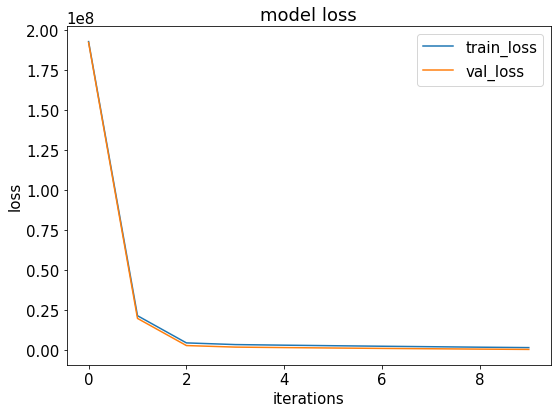

In [97]:
# 損失値をプロット
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(8,6))
plt.title('model loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.tight_layout()
plt.show()

## 【問題5】MNISTのモデルを作成
---
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。

3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。

スクラッチで実装したモデルの再現を目指してください。

## データセットの用意

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# One-hotエンコーダー
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


In [99]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
    
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adagrad(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
    
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy


# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
    
    
_, test_acc = evaluate(X_test, y_test_one_hot)
print("test_acc : {:.3f}".format(test_acc))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, loss : 2.0218, val_loss : 21.0104, val_acc : 0.719
Epoch 1, loss : 2.9081, val_loss : 15.9139, val_acc : 0.759
Epoch 2, loss : 3.6128, val_loss : 13.6094, val_acc : 0.779
Epoch 3, loss : 4.2210, val_loss : 12.2561, val_acc : 0.791
Epoch 4, loss : 4.7659, val_loss : 11.3128, val_acc : 0.800
Epoch 5, loss : 5.2650, val_loss : 10.5962, val_acc : 0.805
Epoch 6, loss : 5.7287, val_loss : 10.0038, val_acc : 0.810
Epoch 7, loss : 6.1637, val_loss : 9.5122, val_acc : 0.814
Epoch 8, loss : 6.5749, val_l